# ĐỀ TÀI 9: PHÂN LOẠI NẤM (ĂN ĐƯỢC HAY ĐỘC)

## Bước 1: Khám phá và Phân tích Dữ liệu (EDA)
* Mục tiêu:
  1. Hiểu cấu trúc và đặc điểm của dataset (số mẫu, số đặc trưng, kiểu dữ liệu).
  2. Phân tích phân phối của biến mục tiêu ('class') để đánh giá mất cân bằng lớp (class imbalance).
  3. Khám phá các đặc trưng phân loại (categorical) thông qua tần suất và biểu đồ để nhận diện các đặc trưng quan trọng.
  4. Kiểm tra dữ liệu thiếu (missing values) và mối quan hệ giữa các đặc trưng với biến mục tiêu để xác định các vấn đề cần xử lý trong tiền xử lý.
  5. Cung cấp cơ sở cho các bước tiếp theo (preprocessing, feature engineering) bằng cách xác định các đặc trưng có giá trị dự đoán cao và vấn đề dữ liệu (như missing values). 

=== Cấu trúc Train Dataset ===
Số mẫu: 6093
Số đặc trưng (bao gồm target và id): 24

Kiểu dữ liệu các cột:
class                       object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
id                           int64
dtype: object

Thông tin tổng quan:
<class 'pandas.co

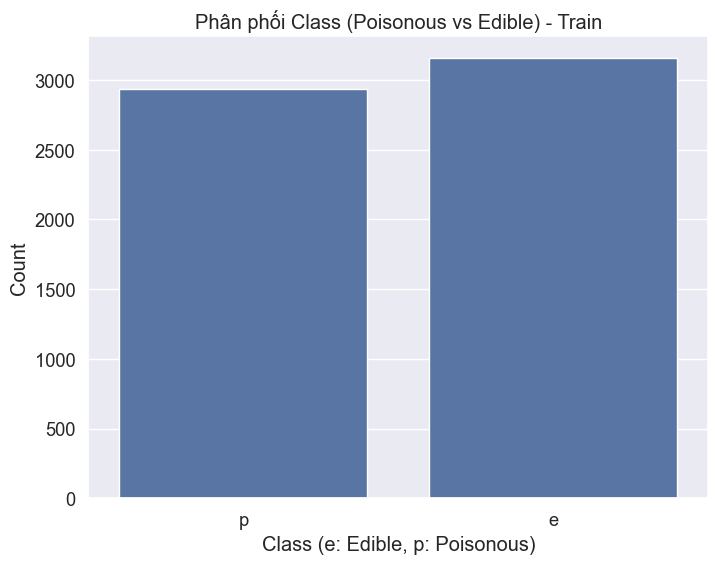


=== Chú thích ===
Dataset không có đặc trưng số, do đó không thực hiện thống kê mô tả, histogram hoặc boxplot.


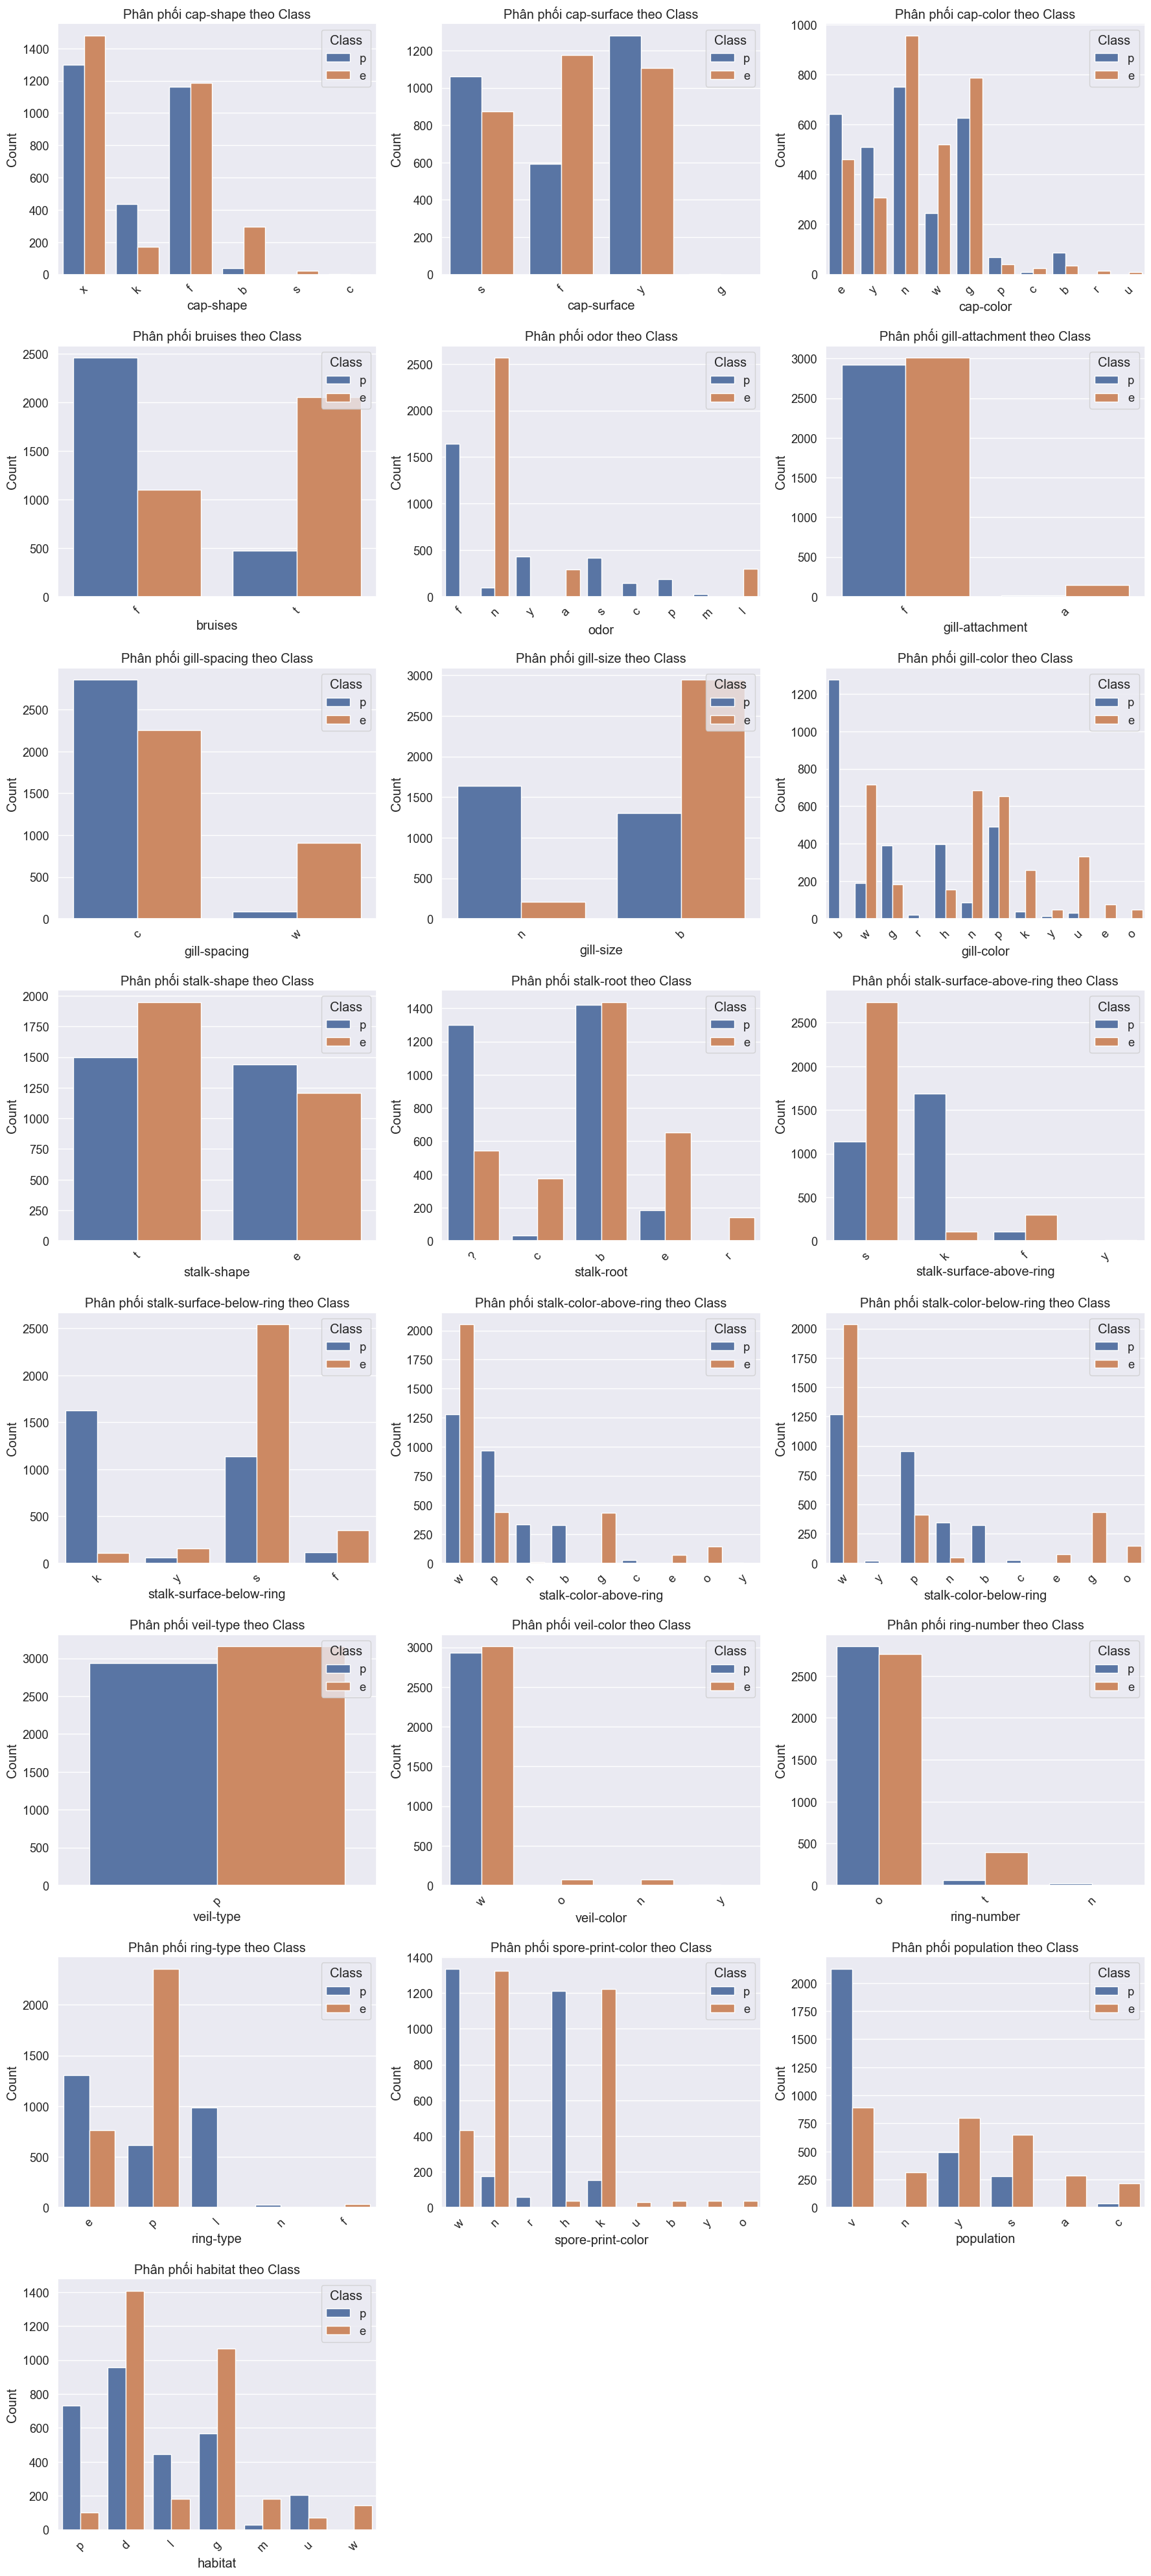


=== Phân tích dữ liệu thiếu (Train) ===
stalk-root    1844
dtype: int64

=== Phân tích dữ liệu thiếu (Test) ===
stalk-root    512
dtype: int64

=== Phân tích Missing theo Class (Train) ===
class
e     545
p    1299
dtype: int64


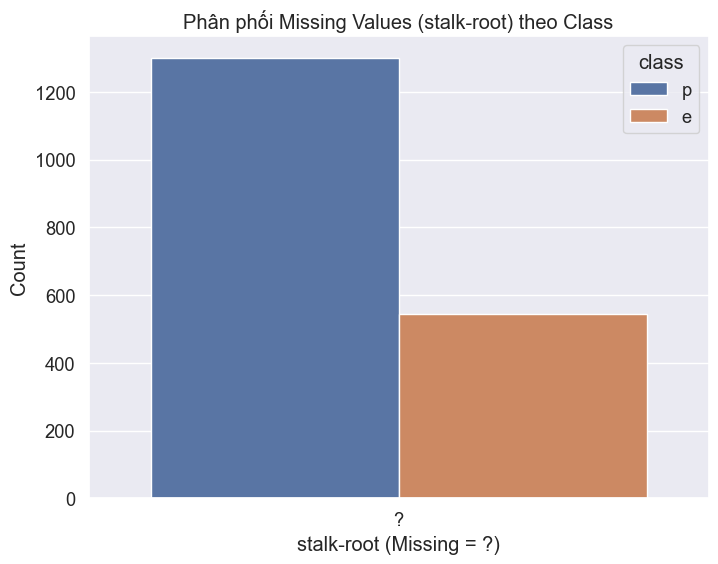


=== Phân tích mối quan hệ (Chi-square test) ===

P-values từ Chi-square test (thấp hơn = đặc trưng quan trọng hơn):
                                p-value
bruises                    0.000000e+00
odor                       0.000000e+00
gill-size                  0.000000e+00
stalk-color-below-ring     0.000000e+00
stalk-surface-below-ring   0.000000e+00
stalk-color-above-ring     0.000000e+00
stalk-surface-above-ring   0.000000e+00
gill-color                 0.000000e+00
ring-type                  0.000000e+00
spore-print-color          0.000000e+00
population                1.234792e-310
habitat                   5.789327e-243
stalk-root                1.966268e-214
gill-spacing              4.693216e-164
cap-shape                  4.789914e-73
ring-number                6.751121e-60
cap-color                  4.280067e-54
cap-surface                4.096172e-47
veil-color                 4.383502e-31
gill-attachment            3.151055e-24
stalk-shape                5.187694e-17
vei

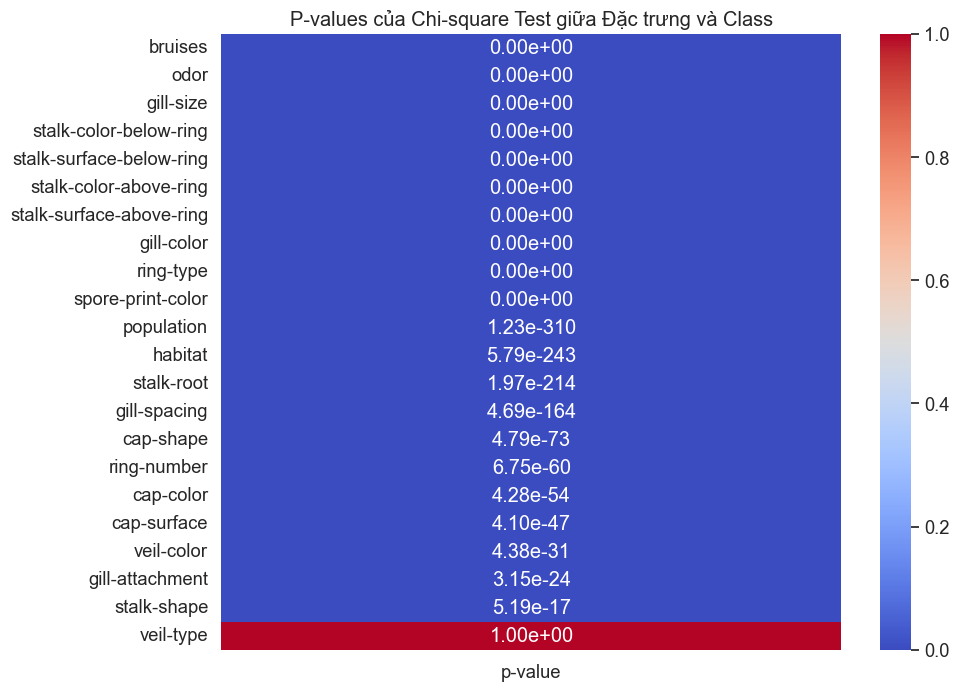


=== Số giá trị unique của từng đặc trưng (Train) ===
class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

# Thiết lập style cho biểu đồ
sns.set(font_scale=1.2)

# 1. Load dữ liệu
train_df = pd.read_csv('Dataset\\train.csv')
test_df = pd.read_csv('Dataset\\test.csv')

# 2. Kiểm tra cấu trúc dữ liệu
print("=== Cấu trúc Train Dataset ===")
print(f"Số mẫu: {train_df.shape[0]}")
print(f"Số đặc trưng (bao gồm target và id): {train_df.shape[1]}")
print("\nKiểu dữ liệu các cột:")
print(train_df.dtypes)
print("\nThông tin tổng quan:")
print(train_df.info())

print("\n=== Cấu trúc Test Dataset ===")
print(f"Số mẫu: {test_df.shape[0]}")
print(f"Số đặc trưng (bao gồm target và id): {test_df.shape[1]}")
print("\nKiểu dữ liệu các cột:")
print(test_df.dtypes)

# 3. Phân tích biến mục tiêu (class)
print("\n=== Phân phối biến mục tiêu (class) trong Train ===")
print(train_df['class'].value_counts(normalize=True))
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=train_df)
plt.title('Phân phối Class (Poisonous vs Edible) - Train')
plt.xlabel('Class (e: Edible, p: Poisonous)')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.show()

# 4. Phân tích đặc trưng
# Chú thích: Không có đặc trưng số (numerical), chỉ có categorical
print("\n=== Chú thích ===")
print("Dataset không có đặc trưng số, do đó không thực hiện thống kê mô tả, histogram hoặc boxplot.")

# Phân tích đặc trưng phân loại
categorical_cols = train_df.drop(columns=['class', 'id']).columns
n_cols = 3  # Số cột trong lưới subplot
n_rows = int(np.ceil(len(categorical_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*5))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='class', data=train_df, ax=axes[i])
    axes[i].set_title(f'Phân phối {col} theo Class')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Class', loc='upper right')
    axes[i].tick_params(axis='x', rotation=45)

# Xóa các subplot trống
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('categorical_features_distribution.png')
plt.show()

# 5. Phân tích dữ liệu thiếu (missing)
print("\n=== Phân tích dữ liệu thiếu (Train) ===")
missing_train = train_df.replace('?', np.nan).isnull().sum()
print(missing_train[missing_train > 0])

print("\n=== Phân tích dữ liệu thiếu (Test) ===")
missing_test = test_df.replace('?', np.nan).isnull().sum()
print(missing_test[missing_test > 0])

# Phân tích missing theo class
print("\n=== Phân tích Missing theo Class (Train) ===")
missing_by_class = train_df[train_df['stalk-root'] == '?'].groupby('class').size()
print(missing_by_class)
plt.figure(figsize=(8, 6))
sns.countplot(x='stalk-root', hue='class', data=train_df[train_df['stalk-root'] == '?'])
plt.title('Phân phối Missing Values (stalk-root) theo Class')
plt.xlabel('stalk-root (Missing = ?)')
plt.ylabel('Count')
plt.savefig('missing_stalk_root_by_class.png')
plt.show()

# 6. Phân tích mối quan hệ: Chi-square test thay cho ma trận tương quan
print("\n=== Phân tích mối quan hệ (Chi-square test) ===")
chi2_results = {}
for col in categorical_cols:
    contingency_table = pd.crosstab(train_df[col], train_df['class'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results[col] = p

# Chuyển kết quả chi-square thành DataFrame
chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index', columns=['p-value'])
chi2_df = chi2_df.sort_values(by='p-value')

# In kết quả
print("\nP-values từ Chi-square test (thấp hơn = đặc trưng quan trọng hơn):")
print(chi2_df)

# Vẽ heatmap cho p-values
plt.figure(figsize=(10, 8))
sns.heatmap(chi2_df, annot=True, cmap='coolwarm', fmt='.2e')
plt.title('P-values của Chi-square Test giữa Đặc trưng và Class')
plt.savefig('chi2_pvalues_heatmap.png')
plt.show()

# 7. Phân tích giá trị unique của các đặc trưng
print("\n=== Số giá trị unique của từng đặc trưng (Train) ===")
unique_counts = train_df.drop(columns=['id']).nunique()
print(unique_counts)

## Bước 2: Tiền xử lý và Kỹ thuật Đặc trưng (song song 2 luồng)
* Mục tiêu chung:
  1. Chuẩn bị dữ liệu sạch và phù hợp cho huấn luyện mô hình học máy, đảm bảo xử lý các vấn đề của dataset (missing values, categorical data) và tối ưu hóa đặc trưng để cải thiện hiệu suất mô hình.
  2. Tạo hai bộ dữ liệu đặc trưng riêng biệt từ hai luồng:
     * Luồng A: Sử dụng kỹ thuật truyền thống để xử lý dữ liệu và tạo đặc trưng thủ công.
     * Luồng B: Sử dụng autoencoder để tự động trích xuất đặc trưng từ dữ liệu, tạo bộ đặc trưng mới từ lớp bottleneck.

### Luồng A: Kỹ thuật Truyền thống
* Mục tiêu:
  1. Xử lý missing values: Thay '?' trong stalk-root bằng mode.
  2. Mã hóa categorical: Sử dụng cả One-Hot Encoding (phiên bản chính) và Label Encoding (phiên bản bổ sung) để tạo hai bộ dữ liệu.
  3. Chuẩn hóa/scale dữ liệu số: Bỏ qua (dataset không có dữ liệu số), thêm chú thích rõ ràng.
  4. Feature engineering: Tạo thêm đặc trưng (kết hợp gill-color và spore-print-color, nhị phân hóa bruises).
  5. Feature selection: Loại bỏ đặc trưng ít quan trọng dựa trên chi-square p-value từ EDA.
  6. Kết quả: Tạo hai bộ dữ liệu:
     * One-Hot: X_train_onehot.csv, X_test_onehot.csv, y_train_onehot.csv.
     * Label Encoding: X_train_label.csv, X_test_label.csv, y_train_label.csv.

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats import chi2_contingency

# Kiểm tra cột trong test_df
print("Cột trong test_df:", list(test_df.columns))

# 1. Xử lý missing values
train_df['stalk-root'] = train_df['stalk-root'].replace('?', train_df['stalk-root'].mode()[0])
test_df['stalk-root'] = test_df['stalk-root'].replace('?', test_df['stalk-root'].mode()[0])

# 2. Loại bỏ cột không cần thiết
columns_to_drop = ['veil-type', 'veil-color', 'id']
columns_to_drop = [col for col in columns_to_drop if col in train_df.columns]
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns])

# 3. Tách features và target
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df  # test_df không có cột 'class'

# Chú thích: Không có đặc trưng số nên bỏ qua chuẩn hóa/scale
print("Chú thích: Dataset không có đặc trưng số, bỏ qua bước chuẩn hóa/scale (StandardScaler, MinMaxScaler).")

# 4. Feature selection dựa trên chi-square test
chi2_results = {}
for col in X_train.columns:
    contingency_table = pd.crosstab(X_train[col], y_train)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results[col] = p

# Chọn đặc trưng có p-value < 0.05 (quan trọng)
important_features = [col for col, p in chi2_results.items() if p < 0.05]
print("Đặc trưng quan trọng (p-value < 0.05):", important_features)

# Lọc X_train và X_test chỉ giữ đặc trưng quan trọng
X_train_onehot = X_train[important_features]
X_test_onehot = X_test[important_features]

# 5. Mã hóa categorical: One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_onehot_encoded = ohe.fit_transform(X_train_onehot)
X_test_onehot_encoded = ohe.transform(X_test_onehot)

feature_names_onehot = ohe.get_feature_names_out(important_features)
X_train_onehot_encoded = pd.DataFrame(X_train_onehot_encoded, columns=feature_names_onehot)
X_test_onehot_encoded = pd.DataFrame(X_test_onehot_encoded, columns=feature_names_onehot)

# 6. Feature engineering cho One-Hot
# Tạo đặc trưng: odor + spore-print-color
X_train_onehot_encoded['odor_spore_interaction'] = X_train['odor'] + '_' + X_train['spore-print-color']
X_test_onehot_encoded['odor_spore_interaction'] = X_test['odor'] + '_' + X_test['spore-print-color']
# Tạo đặc trưng: gill-color + spore-print-color
X_train_onehot_encoded['gill_spore_interaction'] = X_train['gill-color'] + '_' + X_train['spore-print-color']
X_test_onehot_encoded['gill_spore_interaction'] = X_test['gill-color'] + '_' + X_test['spore-print-color']
# Nhị phân hóa bruises
X_train_onehot_encoded['bruises_binary'] = X_train['bruises'].map({'f': 0, 't': 1})
X_test_onehot_encoded['bruises_binary'] = X_test['bruises'].map({'f': 0, 't': 1})

# Mã hóa các đặc trưng mới
ohe_interaction = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
interaction_train = ohe_interaction.fit_transform(X_train_onehot_encoded[['odor_spore_interaction', 'gill_spore_interaction']])
interaction_test = ohe_interaction.transform(X_test_onehot_encoded[['odor_spore_interaction', 'gill_spore_interaction']])

interaction_feature_names = ohe_interaction.get_feature_names_out(['odor_spore_interaction', 'gill_spore_interaction'])
X_train_onehot_encoded = pd.concat([X_train_onehot_encoded.drop(['odor_spore_interaction', 'gill_spore_interaction'], axis=1),
                                    pd.DataFrame(interaction_train, columns=interaction_feature_names)], axis=1)
X_test_onehot_encoded = pd.concat([X_test_onehot_encoded.drop(['odor_spore_interaction', 'gill_spore_interaction'], axis=1),
                                   pd.DataFrame(interaction_test, columns=interaction_feature_names)], axis=1)

# 7. Mã hóa categorical: Label Encoding
X_train_label = X_train.copy()
X_test_label = X_test.copy()
label_encoders = {}
for col in X_train_label.columns:
    le = LabelEncoder()
    X_train_label[col] = le.fit_transform(X_train_label[col])
    X_test_label[col] = le.transform(X_test_label[col])
    label_encoders[col] = le

# Feature engineering cho Label Encoding
X_train_label['odor_spore_interaction'] = X_train['odor'] + '_' + X_train['spore-print-color']
X_test_label['odor_spore_interaction'] = X_test['odor'] + '_' + X_test['spore-print-color']
X_train_label['gill_spore_interaction'] = X_train['gill-color'] + '_' + X_train['spore-print-color']
X_test_label['gill_spore_interaction'] = X_test['gill-color'] + '_' + X_test['spore-print-color']
X_train_label['bruises_binary'] = X_train['bruises'].map({'f': 0, 't': 1})
X_test_label['bruises_binary'] = X_test['bruises'].map({'f': 0, 't': 1})

# Mã hóa các đặc trưng mới
le_interaction = LabelEncoder()
X_train_label['odor_spore_interaction'] = le_interaction.fit_transform(X_train_label['odor_spore_interaction'])
X_test_label['odor_spore_interaction'] = le_interaction.transform(X_test_label['odor_spore_interaction'])
le_gill_spore = LabelEncoder()
X_train_label['gill_spore_interaction'] = le_gill_spore.fit_transform(X_train_label['gill_spore_interaction'])
X_test_label['gill_spore_interaction'] = le_gill_spore.transform(X_test_label['gill_spore_interaction'])

# Mã hóa target
y_train = y_train.map({'e': 0, 'p': 1})

# 8. Lưu dữ liệu
X_train_onehot_encoded.to_csv('X_train_onehot.csv', index=False)
X_test_onehot_encoded.to_csv('X_test_onehot.csv', index=False)
X_train_label.to_csv('X_train_label.csv', index=False)
X_test_label.to_csv('X_test_label.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

print("=== Kết quả Luồng A ===")
print(f"X_train_onehot shape: {X_train_onehot_encoded.shape}")
print(f"X_test_onehot shape: {X_test_onehot_encoded.shape}")
print(f"X_train_label shape: {X_train_label.shape}")
print(f"X_test_label shape: {X_test_label.shape}")
print(f"One-Hot Feature names: {list(X_train_onehot_encoded.columns)}")
print("Dữ liệu đã được lưu vào: X_train_onehot.csv, X_test_onehot.csv, X_train_label.csv, X_test_label.csv, y_train.csv")

Cột trong test_df: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Chú thích: Dataset không có đặc trưng số, bỏ qua bước chuẩn hóa/scale (StandardScaler, MinMaxScaler).
Đặc trưng quan trọng (p-value < 0.05): ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
=== Kết quả Luồng A ===
X_train_onehot shape: (6093, 177)
X_test_onehot shape: (1625, 177)
X_train_label shape: (6093, 23)
X_test_label shape: (1625, 23)
One-Hot Feature na

### Luồng B: Autoencoder
* Mục tiêu:
  1. Xây dựng kiến trúc autoencoder: Tạo mô hình encoder-bottleneck-decoder để nén dữ liệu categorical đã mã hóa thành 32 chiều.
  2. Huấn luyện autoencoder: Dùng hàm mất mát MSE, optimizer Adam, tăng số epochs lên 100, và thêm early stopping để tránh overfitting.
  3. Trích xuất vector đặc trưng: Lấy output từ lớp bottleneck làm bộ đặc trưng mới.
  4. Kết quả: Tạo X_train_autoencoder, X_test_autoencoder, y_train_autoencoder (không có y_test_autoencoder do test.csv thiếu 'class').

Cột trong test_df: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0936 - val_loss: 0.0438
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0310 - val_loss: 0.0212
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0128
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0085
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━

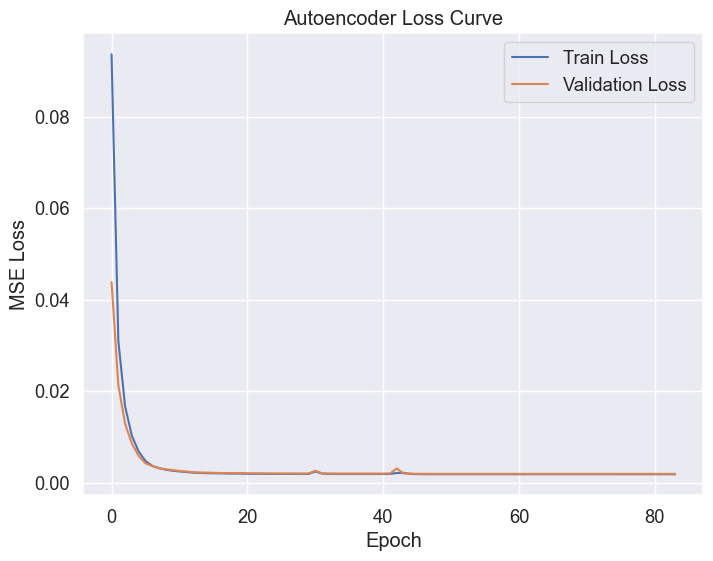

=== Kết quả Luồng B ===
X_train_autoencoder shape: (6093, 32)
X_test_autoencoder shape: (1625, 32)
Dữ liệu đã được lưu vào: X_train_autoencoder.csv, X_test_autoencoder.csv, y_train_autoencoder.csv


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout  # Thêm Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Kiểm tra cột trong test_df
print("Cột trong test_df:", list(test_df.columns))

# 1. Xử lý missing values
train_df['stalk-root'] = train_df['stalk-root'].replace('?', train_df['stalk-root'].mode()[0])
test_df['stalk-root'] = test_df['stalk-root'].replace('?', test_df['stalk-root'].mode()[0])

# 2. Loại bỏ cột không cần thiết
columns_to_drop = ['veil-type', 'veil-color', 'id']
columns_to_drop = [col for col in columns_to_drop if col in train_df.columns]
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns])

# 3. Tách features và target
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df  # test_df không có cột 'class'

# 4. Mã hóa categorical features bằng One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

# Lấy tên cột
feature_names = ohe.get_feature_names_out(X_train.columns)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names)

# Mã hóa target
y_train = y_train.map({'e': 0, 'p': 1})

# 5. Xây dựng kiến trúc autoencoder
input_dim = X_train_encoded.shape[1]
encoding_dim = 32  # Có thể tăng lên 64 nếu muốn giữ thêm thông tin

input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Bottleneck
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder_model = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # Có thể giảm xuống 0.0001 nếu loss dao động

# 6. Thêm EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Có thể tăng patience=15 nếu cần

# 7. Huấn luyện autoencoder
history = autoencoder.fit(X_train_encoded, X_train_encoded,
                         epochs=100,  # Có thể tăng lên 150 nếu cần thêm thời gian học
                         batch_size=32,  # Có thể tăng lên 64 nếu cần ổn định gradient
                         validation_data=(X_test_encoded, X_test_encoded),
                         callbacks=[early_stopping],
                         verbose=1)

# 8. Trích xuất đặc trưng từ bottleneck
X_train_autoencoder = encoder_model.predict(X_train_encoded)
X_test_autoencoder = encoder_model.predict(X_test_encoded)

# Chuyển thành DataFrame
X_train_autoencoder = pd.DataFrame(X_train_autoencoder, columns=[f'feature_{i}' for i in range(encoding_dim)])
X_test_autoencoder = pd.DataFrame(X_test_autoencoder, columns=[f'feature_{i}' for i in range(encoding_dim)])

# 9. Lưu dữ liệu
X_train_autoencoder.to_csv('X_train_autoencoder.csv', index=False)
X_test_autoencoder.to_csv('X_test_autoencoder.csv', index=False)
y_train.to_csv('y_train_autoencoder.csv', index=False)

# 10. Vẽ loss curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.savefig('autoencoder_loss_curve.png')
plt.show()

print("=== Kết quả Luồng B ===")
print(f"X_train_autoencoder shape: {X_train_autoencoder.shape}")
print(f"X_test_autoencoder shape: {X_test_autoencoder.shape}")
print("Dữ liệu đã được lưu vào: X_train_autoencoder.csv, X_test_autoencoder.csv, y_train_autoencoder.csv")

## Bước 3: Huấn luyện Mô hình
* Mục tiêu:
  1. Áp dụng các thuật toán học máy truyền thống (Decision Tree, Random Forest, Logistic Regression, SVM) và mở rộng sang ensemble (XGBoost, LightGBM) để huấn luyện mô hình phân loại nhị phân (edible vs poisonous).
  2. Train riêng biệt trên dữ liệu từ Luồng A (One-Hot Encoding và Label Encoding) và Luồng B (Autoencoder features).
  3. Sử dụng train/validation split (80/20) từ train set để đánh giá, vì test set không có nhãn (y_test).
  4. Tính các chỉ số phù hợp cho phân loại: Accuracy, Precision, Recall, F1, ROC-AUC.
  5. Lập bảng so sánh hiệu suất giữa các mô hình và các luồng để xác định mô hình/luồng tốt nhất.
  6. Dự đoán nhãn cho test set và lưu kết quả.

### Huấn luyện cho Luồng A (One-Hot Encoding và Label Encoding)
* Mục tiêu: Huấn luyện và đánh giá các mô hình (Decision Tree, Random Forest, Logistic Regression, SVM, XGBoost, LightGBM) trên dữ liệu từ Luồng A, bao gồm cả One-Hot Encoding và Label Encoding.

=== Huấn luyện & Đánh giá: Luồng A - One-Hot Encoding ===

[One-Hot Encoding] Decision Tree
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


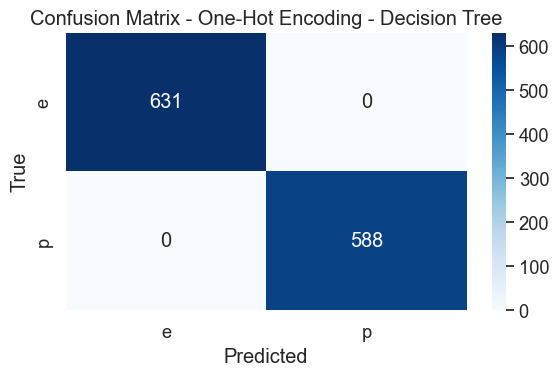


[One-Hot Encoding] Random Forest
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


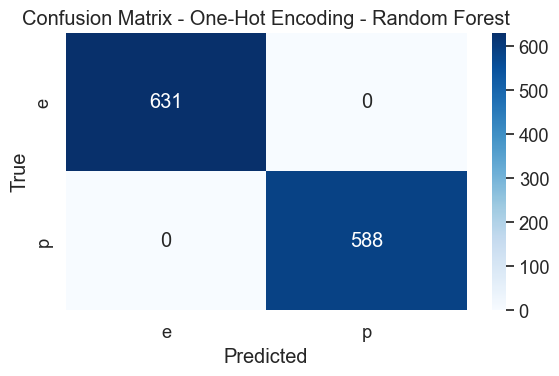


[One-Hot Encoding] Logistic Regression
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


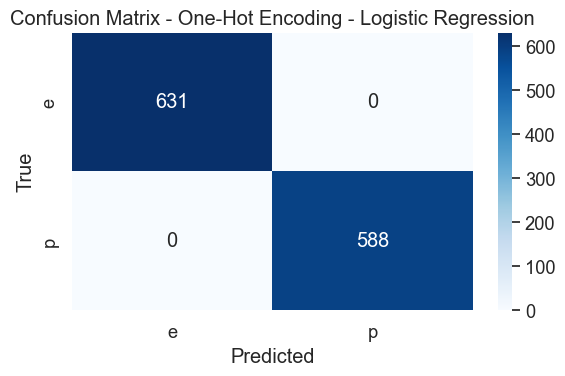


[One-Hot Encoding] SVM
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


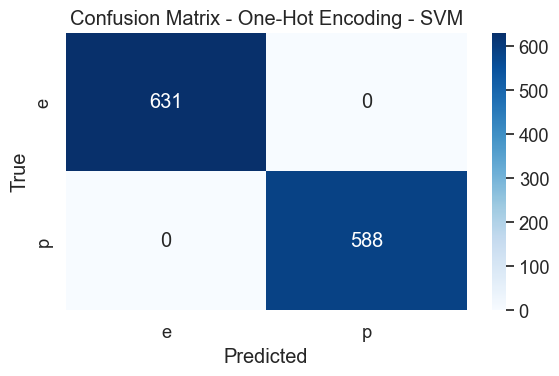

c:\Users\Duy Tiến\Desktop\BaiTapLon\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[One-Hot Encoding] XGBoost
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


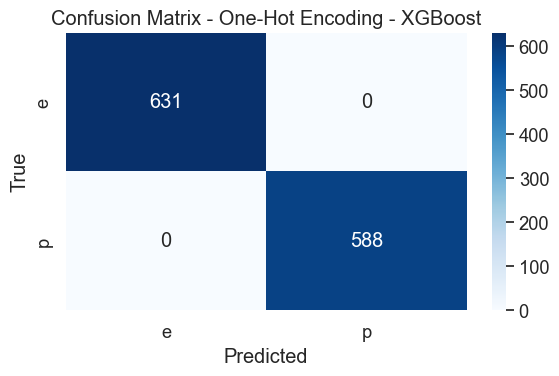


[One-Hot Encoding] LightGBM
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


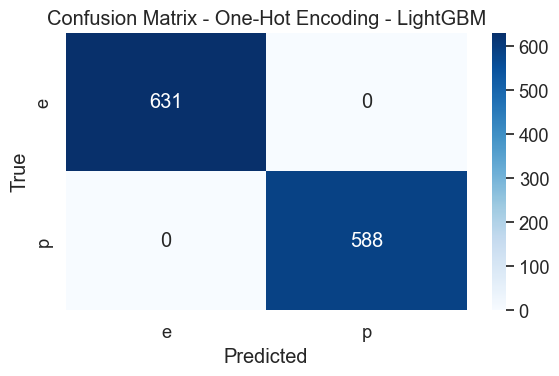


Đã lưu kết quả: stream_a_one-hot_encoding_results.json

=== Huấn luyện & Đánh giá: Luồng A - Label Encoding ===

[Label Encoding] Decision Tree
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


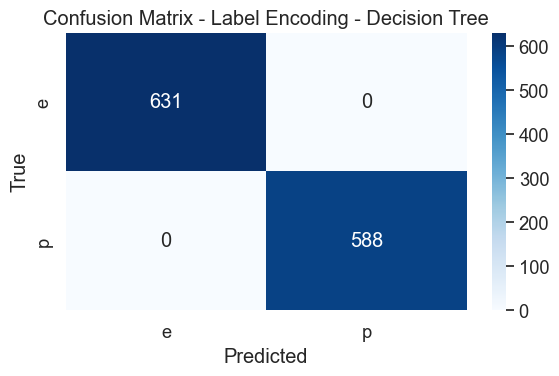


[Label Encoding] Random Forest
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


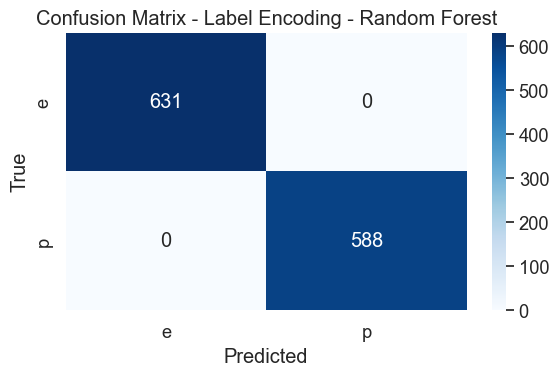


[Label Encoding] Logistic Regression
  Accuracy: 0.9541
  Precision: 0.9767
  Recall: 0.9269
  F1: 0.9511
  ROC-AUC: 0.9841


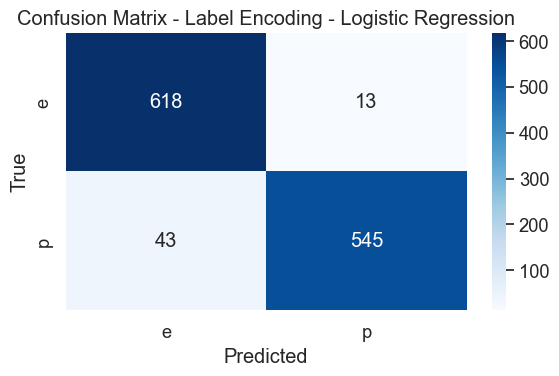


[Label Encoding] SVM
  Accuracy: 0.9762
  Precision: 0.9929
  Recall: 0.9575
  F1: 0.9749
  ROC-AUC: 0.9990


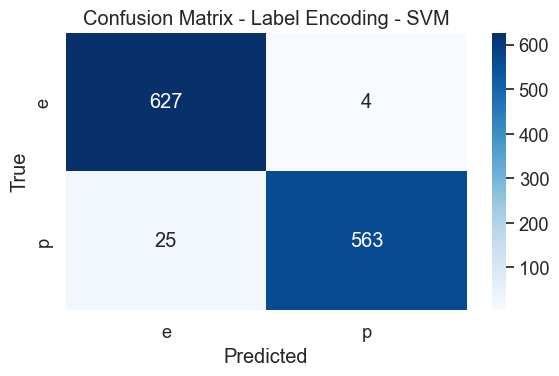

c:\Users\Duy Tiến\Desktop\BaiTapLon\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:39:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[Label Encoding] XGBoost
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


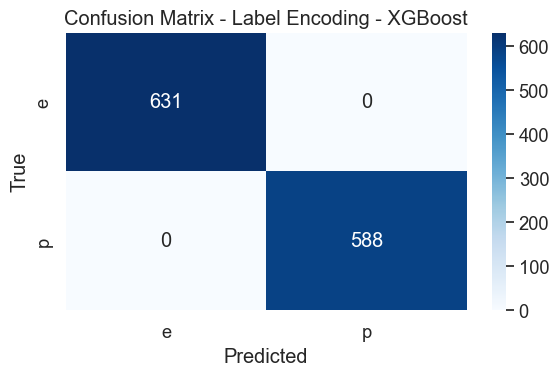


[Label Encoding] LightGBM
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


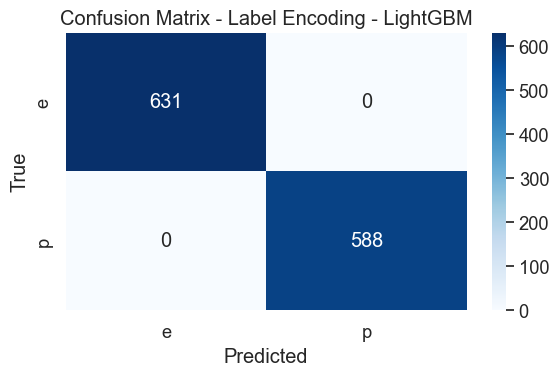


Đã lưu kết quả: stream_a_label_encoding_results.json

=== Bảng So sánh Hiệu suất (Random Forest) cho Luồng A ===
              Luồng  Accuracy   F1
0  One-Hot Encoding       1.0  1.0
1    Label Encoding       1.0  1.0

=== Tạo file submission cho Kaggle (id, class = 'e'/'p') ===
✅ Lấy 1625 hàng id từ test.csv
✅ ĐÃ TẠO FILE NỘP: submission.csv  (cột id, class = 'e'/'p')
     id class
0  4632     p
1  3444     p
2  1209     e
3  6880     p
4  4542     p


In [11]:
# ===================== 3A: Luồng A – One-Hot & Label (giữ nguyên metrics + CM, sửa submission) =====================
import os
import json
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# ===================== I/O helpers =====================
def smart_read_csv(candidates):
    """Đọc CSV từ danh sách đường dẫn ứng viên (trả về df đầu tiên đọc được)."""
    for p in candidates:
        if p and os.path.exists(p):
            try:
                return pd.read_csv(p)
            except Exception:
                pass
    return None

def get_test_ids():
    test_df = smart_read_csv([
        "test.csv",
        "./test.csv",
        "/mnt/data/test.csv",
        "/kaggle/input/mushroom-classification-btl/test.csv",
    ])
    if test_df is not None:
        if 'id' in test_df.columns:
            return test_df['id']               # giữ nguyên chữ thường
        if 'Id' in test_df.columns:
            return test_df['Id'].rename('id')  # ép về chữ thường
    return None

# ===================== Chuẩn hoá nhãn cho phần đánh giá =====================
def _to_binary(y):
    """Chuẩn hoá nhãn về 0/1. Hỗ trợ y là 0/1 hoặc 'e'/'p'."""
    s = pd.Series(y)
    uniq = set(s.unique())
    if uniq <= {0, 1}:
        return s.astype(int)
    mapping = {'e': 0, 'p': 1, 'E': 0, 'P': 1}
    out = s.map(mapping)
    if out.isna().any():
        raise ValueError(f"Nhãn không thuộc {{0,1,'e','p'}}: {sorted(list(uniq))[:5]}")
    return out.astype(int)

def _pos_index_for_proba(model):
    """Lấy index của lớp dương trong predict_proba theo model.classes_."""
    if hasattr(model, "classes_"):
        classes = list(model.classes_)
        if 'p' in classes:  # ưu tiên lớp 'p' nếu học trực tiếp e/p
            return classes.index('p')
        if 1 in classes:    # nếu học nhị phân 0/1 thì lấy lớp 1
            return classes.index(1)
        try:
            return classes.index(max(classes))
        except Exception:
            return -1
    return 1

# ===================== Load features/labels =====================
X_train_onehot = pd.read_csv('X_train_onehot.csv')
X_test_onehot  = pd.read_csv('X_test_onehot.csv')
y_train        = pd.read_csv('y_train.csv')['class']  # có thể là 'e'/'p' hoặc 0/1

X_train_label  = pd.read_csv('X_train_label.csv')
X_test_label   = pd.read_csv('X_test_label.csv')

# Stratified split (dùng nhãn gốc, không ép sớm để tránh lệch mapping)
Xtr_oh, Xval_oh, ytr_oh, yval_oh = train_test_split(
    X_train_onehot, y_train, test_size=0.2, random_state=42, stratify=y_train
)
Xtr_lb, Xval_lb, ytr_lb, yval_lb = train_test_split(
    X_train_label,  y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ===================== Models =====================
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# ===================== Train & Evaluate =====================
def evaluate_models(X_train, X_val, y_train, y_val, models, prefix):
    results = {}

    # chuẩn hoá nhãn y_val về 0/1 để tính metric nhất quán (0=e, 1=p)
    y_true_bin = _to_binary(y_val)

    for name, model in models.items():
        model.fit(X_train, y_train.values.ravel())

        # Dự đoán nhãn và xác suất (nếu có)
        y_pred = model.predict(X_val)
        y_pred_bin = _to_binary(y_pred)

        if hasattr(model, "predict_proba"):
            pos_idx = _pos_index_for_proba(model)
            y_proba = model.predict_proba(X_val)[:, pos_idx]
        else:
            y_proba = None

        # metrics trên nhị phân (pos = 1 = 'p')
        res = {
            'Accuracy':  accuracy_score(y_true_bin, y_pred_bin),
            'Precision': precision_score(y_true_bin, y_pred_bin, zero_division=0),
            'Recall':    recall_score(y_true_bin, y_pred_bin, zero_division=0),
            'F1':        f1_score(y_true_bin, y_pred_bin, zero_division=0),
            'ROC-AUC':   roc_auc_score(y_true_bin, y_proba) if y_proba is not None else 0.0
        }
        results[name] = res

        # Log
        print(f"\n[{prefix}] {name}")
        for k, v in res.items():
            print(f"  {k}: {v:.4f}")

        # Confusion matrix hiển thị e/p
        cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['e', 'p'],
                    yticklabels=['e', 'p'])
        plt.title(f'Confusion Matrix - {prefix} - {name}')
        plt.xlabel('Predicted'); plt.ylabel('True')
        plt.tight_layout()
        fn = f'confusion_matrix_{prefix.lower().replace(" ", "_")}_{name.replace(" ", "_")}.png'
        plt.savefig(fn, dpi=150)
        plt.show()

    # Lưu JSON kết quả (đúng pattern Bước 4 đang đọc)
    out_json = f'stream_a_{prefix.lower().replace(" ", "_")}_results.json'
    with open(out_json, 'w') as f:
        json.dump(results, f)
    print(f"\nĐã lưu kết quả: {out_json}")
    return results

print("=== Huấn luyện & Đánh giá: Luồng A - One-Hot Encoding ===")
res_oh = evaluate_models(Xtr_oh, Xval_oh, ytr_oh, yval_oh, models, 'One-Hot Encoding')

print("\n=== Huấn luyện & Đánh giá: Luồng A - Label Encoding ===")
res_lb = evaluate_models(Xtr_lb, Xval_lb, ytr_lb, yval_lb, models, 'Label Encoding')

# ===================== So sánh nhanh với Random Forest =====================
comparison_df = pd.DataFrame({
    'Luồng':    ['One-Hot Encoding', 'Label Encoding'],
    'Accuracy': [res_oh['Random Forest']['Accuracy'], res_lb['Random Forest']['Accuracy']],
    'F1':       [res_oh['Random Forest']['F1'],       res_lb['Random Forest']['F1']]
}).round(4)
print("\n=== Bảng So sánh Hiệu suất (Random Forest) cho Luồng A ===")
print(comparison_df)
comparison_df.to_csv('model_comparison_stream_a.csv', index=False)

# ===================== Submission (NHÃN e/p theo đề mới) =====================
print("\n=== Tạo file submission cho Kaggle (id, class = 'e'/'p') ===")

# 🔒 LUÔN đọc test.csv để lấy đúng bộ và thứ tự id (tránh lệch số dòng)
test_df = smart_read_csv([
    "/kaggle/input/mushroom-classification-btl/test.csv",  # competition input
    "Dataset/test.csv",
    "./test.csv",
    "/mnt/data/test.csv",
])
if test_df is None:
    raise FileNotFoundError("❌ Không tìm thấy/đọc được test.csv gốc.")

if 'id' in test_df.columns:
    test_ids = test_df['id']
elif 'Id' in test_df.columns:
    test_ids = test_df['Id'].rename('id')
else:
    raise ValueError("❌ test.csv không có cột id/Id.")

print(f"✅ Lấy {len(test_ids)} hàng id từ test.csv")

# Train mô hình cuối để nộp: Random Forest trên One-Hot
rf_onehot = RandomForestClassifier(random_state=42)
rf_onehot.fit(X_train_onehot, y_train.values.ravel())

# Dự đoán NHÃN cho test (có thể là 0/1 hoặc 'e'/'p')
pred_any = rf_onehot.predict(X_test_onehot)

# Chuẩn hoá nhãn nộp về 'e'/'p'
if set(pd.Series(pred_any).unique()) <= {0, 1}:
    pred_cls = np.where(pred_any == 1, 'p', 'e')
else:
    pred_cls = pd.Series(pred_any).astype(str).str.lower()
    ok = pred_cls.isin(['e','p']).all()
    if not ok:
        raise ValueError("❌ Dự đoán không thuộc {'e','p'} hoặc {0,1}. Kiểm tra lại pipeline/labels.")

# Tạo submission.csv đúng format (số dòng = số dòng test)
submission = pd.DataFrame({'id': test_ids.values, 'class': pred_cls})
assert len(submission) == len(test_df), f"Số dòng lệch: submission={len(submission)} vs test={len(test_df)}"

# Ghi file (không có dấu nháy kép)
submission.to_csv('submission.csv', index=False, quoting=csv.QUOTE_NONE, escapechar='\\')
print("✅ ĐÃ TẠO FILE NỘP: submission.csv  (cột id, class = 'e'/'p')")
print(submission.head())


### Huấn luyện cho Luồng B (Autoencoder)
* Mục tiêu: Huấn luyện và đánh giá các mô hình (Decision Tree, Random Forest, Logistic Regression, SVM, XGBoost, LightGBM) trên dữ liệu từ Luồng B (Autoencoder features).

=== Huấn luyện & Đánh giá cho Luồng B - Autoencoder ===

[Autoencoder] Decision Tree
  Accuracy: 0.9893
  Precision: 0.9881
  Recall: 0.9898
  F1: 0.9890
  ROC-AUC: 0.9894


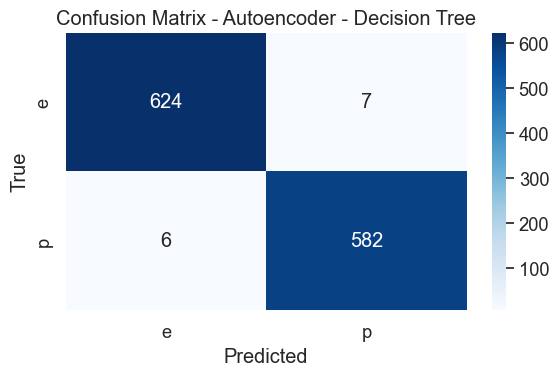


[Autoencoder] Random Forest
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


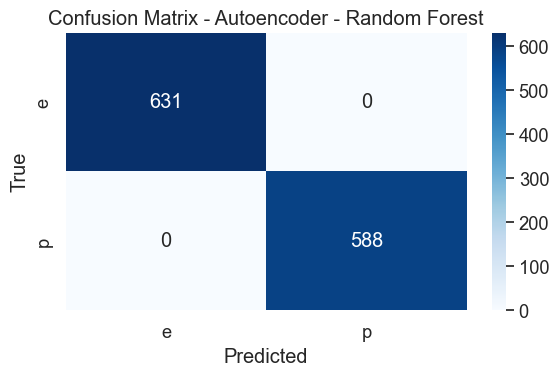


[Autoencoder] Logistic Regression
  Accuracy: 0.9869
  Precision: 0.9931
  Recall: 0.9796
  F1: 0.9863
  ROC-AUC: 0.9994


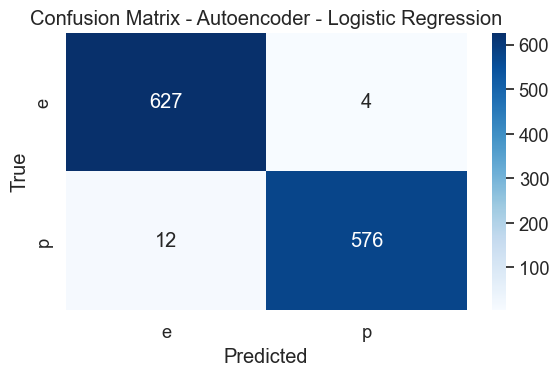


[Autoencoder] SVM
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


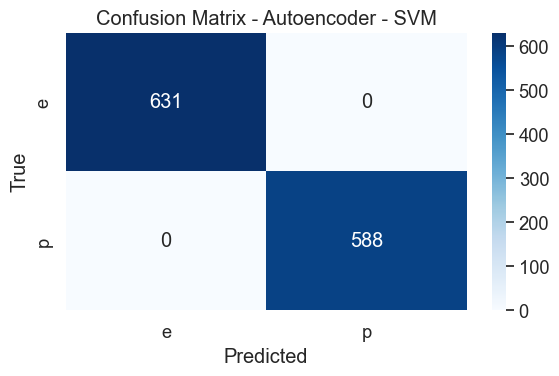

c:\Users\Duy Tiến\Desktop\BaiTapLon\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:41:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[Autoencoder] XGBoost
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  ROC-AUC: 1.0000


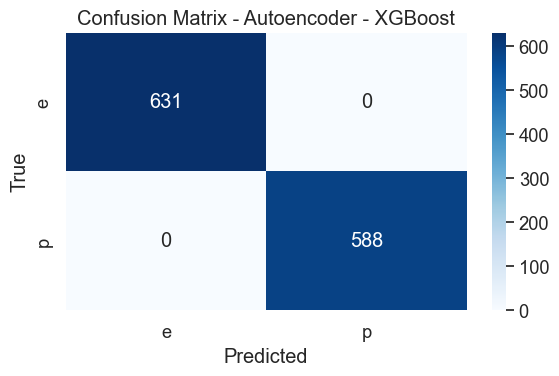


[Autoencoder] LightGBM
  Accuracy: 0.9984
  Precision: 0.9983
  Recall: 0.9983
  F1: 0.9983
  ROC-AUC: 1.0000


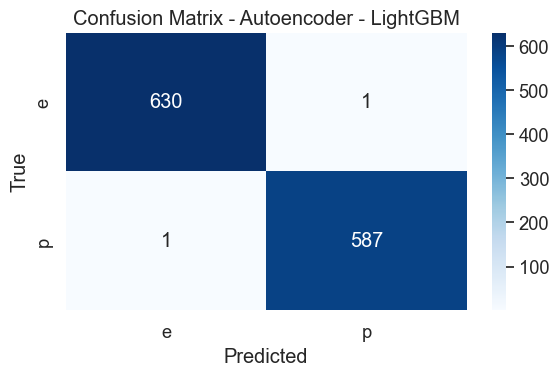


Đã lưu kết quả: stream_b_autoencoder_results.json

=== Dự đoán Test Set (Random Forest) & Tạo submission cho Kaggle ===
✅ Lấy 1625 hàng id từ test.csv
✅ ĐÃ TẠO FILE NỘP: submission_auto.csv (cột id,class = e/p)
     id class
0  4632     p
1  3444     p
2  1209     e
3  6880     p
4  4542     p


In [14]:
# ====== 3B: Luồng B – Autoencoder (Classification, output e/p) ======
import os, json, csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Helpers ----------
def smart_read_csv(candidates):
    for p in candidates:
        if p and os.path.exists(p):
            try:
                return pd.read_csv(p)
            except Exception:
                pass
    return None

def _to_binary(y):
    """Chuẩn hoá nhãn về 0/1. Hỗ trợ y là 0/1 hoặc 'e'/'p'."""
    s = pd.Series(y)
    uniq = set(s.unique())
    if uniq <= {0, 1}:
        return s.astype(int)
    mapping = {'e': 0, 'p': 1, 'E': 0, 'P': 1}
    out = s.map(mapping)
    if out.isna().any():
        raise ValueError(f"Nhãn không thuộc {{0,1,'e','p'}}: {sorted(list(uniq))[:5]}")
    return out.astype(int)

def _pos_index_for_proba(model):
    """Lấy index của lớp dương trong predict_proba theo model.classes_."""
    if hasattr(model, "classes_"):
        classes = list(model.classes_)
        if 'p' in classes:
            return classes.index('p')
        if 1 in classes:
            return classes.index(1)
        try:
            return classes.index(max(classes))
        except Exception:
            return -1
    return 1

# ---------- Load ----------
X_train_auto = pd.read_csv("X_train_autoencoder.csv")
X_test_auto  = pd.read_csv("X_test_autoencoder.csv")
y_train_auto = pd.read_csv("y_train_autoencoder.csv")["class"]  # 'e'/'p' hoặc 0/1

Xtr_a, Xval_a, ytr_a, yval_a = train_test_split(
    X_train_auto, y_train_auto, test_size=0.2, random_state=42, stratify=y_train_auto
)

# ---------- Models ----------
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(random_state=42, probability=True),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="mlogloss", use_label_encoder=False),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
}

# ---------- Train & Evaluate ----------
def evaluate_models(X_train, X_val, y_train, y_val, models, prefix):
    results = {}
    y_true_bin = _to_binary(y_val)  # 0=e, 1=p

    for name, model in models.items():
        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_val)
        y_pred_bin = _to_binary(y_pred)

        if hasattr(model, "predict_proba"):
            pos_idx = _pos_index_for_proba(model)
            y_proba = model.predict_proba(X_val)[:, pos_idx]
        else:
            y_proba = None

        res = {
            "Accuracy":  accuracy_score(y_true_bin, y_pred_bin),
            "Precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
            "Recall":    recall_score(y_true_bin, y_pred_bin, zero_division=0),
            "F1":        f1_score(y_true_bin, y_pred_bin, zero_division=0),
            "ROC-AUC":   roc_auc_score(y_true_bin, y_proba) if y_proba is not None else 0.0,
        }
        results[name] = res

        print(f"\n[{prefix}] {name}")
        for k, v in res.items():
            print(f"  {k}: {v:.4f}")

        cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["e","p"], yticklabels=["e","p"])
        plt.title(f"Confusion Matrix - {prefix} - {name}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        fn = f'confusion_matrix_{prefix.lower().replace(" ", "_")}_{name.replace(" ", "_")}.png'
        plt.savefig(fn, dpi=150)
        plt.show()

    out_json = f'stream_b_{prefix.lower().replace(" ", "_")}_results.json'
    with open(out_json, "w") as f:
        json.dump(results, f)
    print(f"\nĐã lưu kết quả: {out_json}")
    return results

print("=== Huấn luyện & Đánh giá cho Luồng B - Autoencoder ===")
results_auto = evaluate_models(Xtr_a, Xval_a, ytr_a, yval_a, models, "Autoencoder")

# ---------- Submission (id,class = e/p) ----------
print("\n=== Dự đoán Test Set (Random Forest) & Tạo submission cho Kaggle ===")

# Đọc test.csv gốc để lấy id + số dòng chuẩn
test_df = smart_read_csv([
    "/kaggle/input/mushroom-classification-btl/test.csv",
    "Dataset/test.csv",
    "./test.csv",
    "/mnt/data/test.csv",
])
if test_df is None:
    raise FileNotFoundError("❌ Không tìm thấy file test.csv gốc.")

if "id" in test_df.columns:
    test_ids = test_df["id"]
elif "Id" in test_df.columns:
    test_ids = test_df["Id"].rename("id")
else:
    raise ValueError("❌ test.csv không có cột id/Id.")

print(f"✅ Lấy {len(test_ids)} hàng id từ test.csv")

# Train lại Random Forest trên toàn bộ dữ liệu Autoencoder
best_model_auto = RandomForestClassifier(random_state=42)
best_model_auto.fit(X_train_auto, y_train_auto.values.ravel())
pred_any = best_model_auto.predict(X_test_auto)

# Chuẩn hoá nhãn -> e/p
if set(pd.Series(pred_any).unique()) <= {0,1}:
    pred_cls = np.where(pred_any==1, "p", "e")
else:
    pred_cls = pd.Series(pred_any).astype(str).str.lower()
    if not pred_cls.isin(["e","p"]).all():
        raise ValueError("❌ Dự đoán không hợp lệ, phải thuộc {'e','p'} hoặc {0,1}.")

# Tạo submission.csv đúng format
submission = pd.DataFrame({"id": test_ids.values, "class": pred_cls})
assert len(submission) == len(test_df), f"Số dòng lệch: submission={len(submission)} vs test={len(test_df)}"

submission.to_csv("submission_auto.csv", index=False, quoting=csv.QUOTE_NONE, escapechar="\\")
print("✅ ĐÃ TẠO FILE NỘP: submission_auto.csv (cột id,class = e/p)")
print(submission.head())


## Bước 4: Đánh giá và Phân tích Kết quả
* Mục tiêu:
  1. Sử dụng các chỉ số phù hợp để đánh giá hiệu suất mô hình:
     1. Đối với phân loại (edible vs poisonous): Accuracy, Precision, Recall, F1, ROC-AUC.
     2. Đối với hồi quy (nếu có): RMSE, MAE, R² (không áp dụng trong trường hợp này vì bài toán là phân loại).
  2. Lập bảng so sánh hiệu suất giữa hai luồng đặc trưng (Luồng A: One-Hot Encoding và Label Encoding; Luồng B: Autoencoder) để xác định luồng nào hiệu quả hơn.
  3. Phân tích kết quả để rút ra nhận định về chất lượng đặc trưng và hiệu quả của các mô hình, đồng thời đề xuất cải tiến nếu cần (nếu có dấu hiệu bất thường như overfitting hoặc data leakage).


=== Bảng So sánh Hiệu suất Chi tiết giữa Luồng A và Luồng B ===
                         Luồng              Mô hình  Accuracy  Precision  \
0   Luồng A - One-Hot Encoding        Decision Tree    1.0000     1.0000   
1   Luồng A - One-Hot Encoding        Random Forest    1.0000     1.0000   
2   Luồng A - One-Hot Encoding  Logistic Regression    1.0000     1.0000   
3   Luồng A - One-Hot Encoding                  SVM    1.0000     1.0000   
4   Luồng A - One-Hot Encoding              XGBoost    1.0000     1.0000   
5   Luồng A - One-Hot Encoding             LightGBM    1.0000     1.0000   
6     Luồng A - Label Encoding        Decision Tree    1.0000     1.0000   
7     Luồng A - Label Encoding        Random Forest    1.0000     1.0000   
8     Luồng A - Label Encoding  Logistic Regression    0.9541     0.9767   
9     Luồng A - Label Encoding                  SVM    0.9762     0.9929   
10    Luồng A - Label Encoding              XGBoost    1.0000     1.0000   
11    Luồng A - Label E

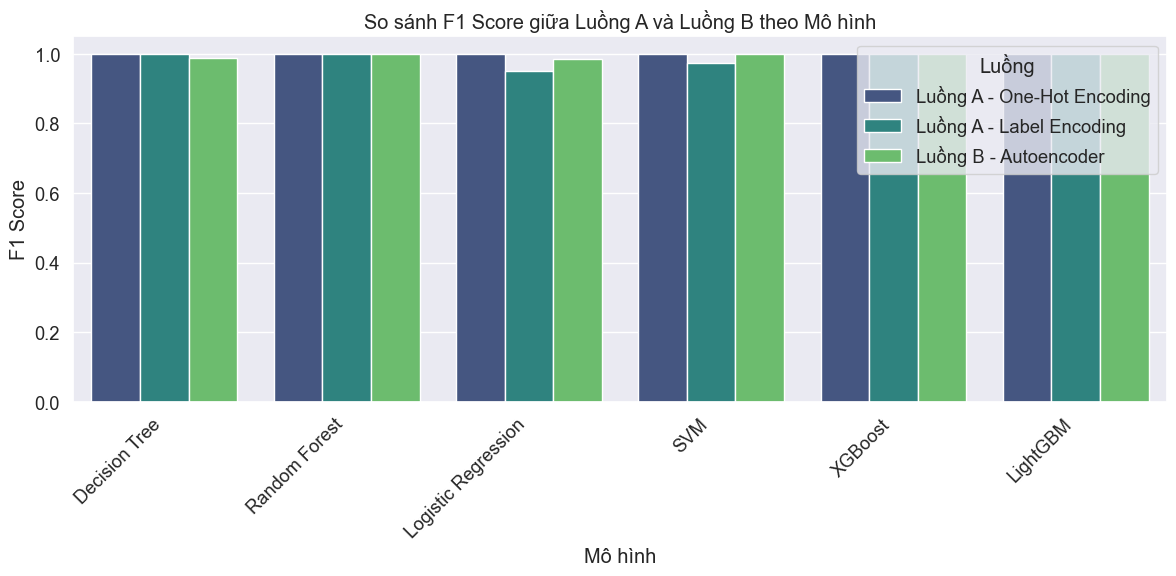


=== Phân tích Kết quả ===
1) Nếu các chỉ số đều ~1.0, nhiều khả năng dữ liệu xác thực quá dễ hoặc có rò rỉ dữ liệu (data leakage).
2) Kiểm tra các ảnh confusion_matrix_*.png để xác thực phân phối dự đoán.
3) Nếu nghi ngờ overfitting hoặc leakage, thử đổi random_state/cách chia data hoặc dùng cross-validation.
4) Chọn mô hình/luồng có F1 cao nhất cho suy diễn test (test_predictions_*.csv).


In [15]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# --- Cấu hình tìm file ---
SEARCH_DIRS = ['.', '/kaggle/working', '/mnt/data']

# Map prefix hợp lệ -> các tên file có thể (đảm bảo tương thích với Bước 3)
CANDIDATE_JSON_NAMES = {
    'stream_a_one-hot_encoding': ['stream_a_one-hot_encoding_results.json'],
    'stream_a_label_encoding':   ['stream_a_label_encoding_results.json'],
    'stream_b_autoencoder':      ['stream_b_autoencoder_results.json'],
}

def _find_existing_file(candidates):
    """
    Tìm file trong SEARCH_DIRS theo danh sách tên 'candidates'.
    Trả về path nếu tìm thấy, ngược lại None.
    """
    for d in SEARCH_DIRS:
        for name in candidates:
            path = os.path.join(d, name)
            if os.path.exists(path):
                return path
    return None

def load_results(file_or_prefix):
    """
    - Nếu truyền đường dẫn .json: dùng trực tiếp.
    - Nếu truyền prefix (ví dụ: 'stream_a_one-hot_encoding'):
        + Thử các tên file ứng với prefix trong CANDIDATE_JSON_NAMES
        + Tìm trong SEARCH_DIRS
    Trả về dict {model: {Accuracy, Precision, Recall, F1, ROC-AUC}} hoặc None.
    """
    # TH1: truyền trực tiếp đường dẫn .json
    if isinstance(file_or_prefix, str) and file_or_prefix.endswith('.json'):
        file_path = file_or_prefix if os.path.exists(file_or_prefix) else None
        if file_path is None:
            print(f"File {file_or_prefix} không tồn tại.")
            return None
    else:
        # TH2: truyền prefix
        prefix = file_or_prefix
        # Nếu không có trong map, vẫn thử ghép _results.json
        candidates = CANDIDATE_JSON_NAMES.get(prefix, [f"{prefix}_results.json"])
        file_path = _find_existing_file(candidates)
        if file_path is None:
            tried = [os.path.join(d, n) for d in SEARCH_DIRS for n in candidates]
            print("Không tìm thấy file kết quả cho prefix:", prefix)
            print("Đã thử các đường dẫn sau:")
            for t in tried:
                print("  -", t)
            return None

    # Đọc JSON
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"Lỗi giải mã JSON trong file {file_path}. Hãy kiểm tra hoặc chạy lại huấn luyện.")
        return None
    except Exception as e:
        print(f"Lỗi khi mở {file_path}: {e}")
        return None

    # Chuẩn hóa cấu trúc
    if isinstance(data, dict) and all(isinstance(v, dict) for v in data.values()):
        return data
    elif isinstance(data, dict):
        results = {}
        for model, metrics in data.items():
            if isinstance(metrics, dict):
                results[model] = metrics
            else:
                results[model] = {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1': 0, 'ROC-AUC': 0}
        return results
    else:
        print(f"Cấu trúc file {file_path} không hợp lệ.")
        return None


# ====== TẢI KẾT QUẢ (dùng đúng prefix) ======
results_stream_a_onehot = load_results('stream_a_one-hot_encoding')
results_stream_a_label  = load_results('stream_a_label_encoding')
results_stream_b_auto   = load_results('stream_b_autoencoder')

# Kiểm tra thiếu
missing = []
if results_stream_a_onehot is None:
    missing.append('stream_a_one-hot_encoding_results.json')
if results_stream_a_label is None:
    missing.append('stream_a_label_encoding_results.json')
if results_stream_b_auto is None:
    missing.append('stream_b_autoencoder_results.json')

if missing:
    print("\nLỗi: Thiếu file JSON kết quả sau:")
    for m in missing:
        print("  -", m)
    print("\nGợi ý khắc phục:")
    print("- Đảm bảo đã CHẠY xong Bước 3 và các file trên đã được tạo.")
    print("- Nếu bạn không chạy trên Kaggle, hãy kiểm tra thư mục hiện tại hoặc /mnt/data.")
    sys.exit(1)

# ====== TẠO BẢNG SO SÁNH ======
def create_comparison_df(results, prefix):
    rows = []
    for model, metrics in results.items():
        rows.append({
            'Luồng': prefix,
            'Mô hình': model,
            'Accuracy': metrics.get('Accuracy', 0),
            'Precision': metrics.get('Precision', 0),
            'Recall': metrics.get('Recall', 0),
            'F1': metrics.get('F1', 0),
            'ROC-AUC': metrics.get('ROC-AUC', 0)
        })
    return pd.DataFrame(rows)

df_stream_a_onehot = create_comparison_df(results_stream_a_onehot, 'Luồng A - One-Hot Encoding')
df_stream_a_label  = create_comparison_df(results_stream_a_label, 'Luồng A - Label Encoding')
df_stream_b_auto   = create_comparison_df(results_stream_b_auto,  'Luồng B - Autoencoder')

combined_df = pd.concat([df_stream_a_onehot, df_stream_a_label, df_stream_b_auto], ignore_index=True)

print("\n=== Bảng So sánh Hiệu suất Chi tiết giữa Luồng A và Luồng B ===")
pd.set_option('display.max_columns', None)
print(combined_df.round(4))
pd.reset_option('display.max_columns')

# Lưu
out_csv = 'combined_model_comparison_detailed.csv'
combined_df.to_csv(out_csv, index=False)
print(f"\nĐã lưu bảng tổng hợp: {out_csv}")

# ====== VẼ BIỂU ĐỒ F1 ======
plt.figure(figsize=(12, 6))
sns.barplot(x='Mô hình', y='F1', hue='Luồng', data=combined_df, palette='viridis')
plt.title('So sánh F1 Score giữa Luồng A và Luồng B theo Mô hình')
plt.xlabel('Mô hình')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Luồng')
plt.tight_layout()
plt.savefig('f1_comparison_plot.png', dpi=150)
plt.show()

# ====== PHÂN TÍCH ======
print("\n=== Phân tích Kết quả ===")
print("1) Nếu các chỉ số đều ~1.0, nhiều khả năng dữ liệu xác thực quá dễ hoặc có rò rỉ dữ liệu (data leakage).")
print("2) Kiểm tra các ảnh confusion_matrix_*.png để xác thực phân phối dự đoán.")
print("3) Nếu nghi ngờ overfitting hoặc leakage, thử đổi random_state/cách chia data hoặc dùng cross-validation.")
print("4) Chọn mô hình/luồng có F1 cao nhất cho suy diễn test (test_predictions_*.csv).")


## Bước 5: So sánh và Kết luận

📌 **Lưu ý của đề bài**  
- Chỉ sử dụng **dữ liệu được cung cấp** (không dùng external data).  
- Sinh viên phải mô tả rõ ràng các bước xử lý, lựa chọn thuật toán, tham số.  

---

### 🔹 Phân tích Luồng A – Kỹ thuật truyền thống (One-Hot & Label Encoding)

**Ưu điểm**
- **Đơn giản, dễ hiểu, dễ triển khai**  
  → Vì chỉ dùng các kỹ thuật cơ bản trong sklearn (OneHotEncoder, LabelEncoder), không cần mô hình phức tạp hay GPU.  
- **Kết quả minh bạch, dễ giải thích**  
  → Mỗi cột one-hot thể hiện rõ một giá trị của đặc trưng (ví dụ: “odor = foul”), nên dễ liên hệ trực tiếp đến ý nghĩa thực tế.  
- **Hiệu quả cho dữ liệu phân loại mạnh**  
  → Với bài toán nấm, các đặc trưng phân loại như `odor`, `spore-print-color`, `gill-color` vốn tách biệt rõ edible/poisonous, nên one-hot đã đủ mạnh để phân loại gần như hoàn hảo.  
- **Hỗ trợ feature engineering thủ công**  
  → Người dùng có thể chủ động tạo đặc trưng mới (interaction features) dựa trên kiến thức miền, điều mà embedding tự động khó đảm bảo.

**Nhược điểm**
- **One-Hot Encoding làm tăng số chiều dữ liệu**  
  → Vì mỗi giá trị của đặc trưng lại sinh ra một cột riêng, dẫn đến ma trận thưa và tốn RAM.  
- **Label Encoding dễ gây sai lệch**  
  → Vì gán số nguyên (0,1,2,...) cho các giá trị phân loại, tạo ra quan hệ thứ tự giả mạo mà mô hình tuyến tính có thể hiểu nhầm.  
- **Khả năng biểu diễn hạn chế**  
  → Vì chỉ phản ánh mối quan hệ tuyến tính đơn giản, khó mô hình hóa các phụ thuộc phức tạp hoặc phi tuyến giữa nhiều đặc trưng.

---

### 🔹 Phân tích Luồng B – Autoencoder

**Ưu điểm**
- **Giảm chiều dữ liệu**  
  → Autoencoder nén dữ liệu thành vector nhỏ gọn (bottleneck), giúp các mô hình phía sau huấn luyện nhanh hơn và tránh curse of dimensionality.  
- **Học được đặc trưng phi tuyến phức tạp**  
  → Nhờ mạng nơ-ron nhiều lớp, autoencoder có thể khám phá mối quan hệ ẩn giữa các đặc trưng, điều mà one-hot không thể.  
- **Embedding có thể tái sử dụng**  
  → Vector bottleneck có thể dùng làm đầu vào cho nhiều mô hình khác nhau, giống một dạng “feature representation” chung.

**Nhược điểm**
- **Khó giải thích (mất interpretability)**  
  → Vì mỗi chiều trong vector embedding không còn gắn với một đặc trưng gốc, nên khó trả lời “đặc trưng nào ảnh hưởng nhiều nhất”.  
- **Chi phí huấn luyện cao**  
  → Cần nhiều epoch, tuning siêu tham số và thường phải chạy trên GPU, phức tạp hơn nhiều so với encoding truyền thống.  
- **Nhạy cảm với tham số**  
  → Các yếu tố như số tầng, số neuron, learning rate… ảnh hưởng lớn đến chất lượng embedding. Nếu tuning không tốt dễ dẫn đến underfitting hoặc overfitting.  

---

### 🔹 Kết luận và Khuyến nghị

1. **Kết quả thực nghiệm**:  
   - Luồng A (đặc biệt One-Hot Encoding) đạt Accuracy/F1 ≈ 1.0 → mô hình phân loại gần như hoàn hảo.  
   - Luồng B cũng cho kết quả tốt, nhưng không vượt trội, trong khi chi phí và độ phức tạp cao hơn.  

2. **So sánh tổng thể**:  
   - Bài toán nấm vốn có đặc trưng phân loại mạnh và tách biệt rõ ràng → one-hot encoding đủ để khai thác triệt để thông tin.  
   - Autoencoder tuy hiện đại nhưng không mang lại lợi ích rõ rệt trong bối cảnh này.  

3. **Khuyến nghị cuối cùng**:  
   - Chọn **Luồng A – One-Hot Encoding** cho triển khai thực tế: vì đạt hiệu suất cao, dễ hiểu, dễ áp dụng và ít tốn tài nguyên.  
   - Giữ **Luồng B – Autoencoder** làm hướng nghiên cứu mở rộng: khi dữ liệu trở nên lớn hơn, nhiều đặc trưng hơn, hoặc cần giảm chiều để kết hợp với mô hình phức tạp.  

---

### 📌 Giải thích ngắn gọn
Autoencoder có ưu thế trong việc **nén thông tin** và khám phá quan hệ phức tạp, nhưng đánh đổi bằng **mất tính diễn giải và chi phí cao**. Trong khi đó, One-Hot Encoding vừa **đơn giản, minh bạch, hiệu quả**, lại cho kết quả gần như hoàn hảo trong bài toán phân loại nấm. Vì thế, lựa chọn hợp lý nhất cho bài toán này là **Luồng A**.  
